In [112]:
# Setup 기본 설정
import numpy as np
import matplotlib.pyplot as plt

#
# markdown display
#
from IPython.display import Markdown, display

#
# Jupyter에서 그래프 크게 보기
#
plt.rcParams["figure.figsize"] = (8, 3)

In [113]:
# RF Mixer - 곱셈(Multiplication)으로 주파수/위상 차이 생성

fs = 2000_000        # Sampling Frequency 2000 kHz 
T  = 0.000125        # 0.125 ms   Y축 
t  = np.linspace(0, T, int(fs*T), endpoint=False)

f_lo = 100_000      # LO = 100 kHz
f_rf = 120_000      # RF = 120 kHz

phase_lo = 0.0
phase_rf = np.deg2rad(30)  # RF 위상 30도

lo = np.cos(2*np.pi*f_lo*t + phase_lo)
rf = np.cos(2*np.pi*f_rf*t + phase_rf)

# RF Mixer: 곱셈
y_rf = lo * rf      # x_out = x1 * x2

# Δf Frequency Difference and Sum
f_dif_1 = abs(f_rf - f_lo)  # 20 kHz
f_sum_1 = abs(f_rf + f_lo)  # 220 kHz

# Δφ Phase Difference and Sum
phase_dif = phase_rf - phase_lo   
phase_sum = phase_rf + phase_lo
phi_diff_deg = np.rad2deg(phase_dif) # 도(degree)로 보기 좋게
phi_pi = phase_dif / np.pi  # π 기준 환산

# Expected Comparison Signals (믹서 곱셈의 결과가 0.5 배이므로)
ideal_020k = 0.5 * np.cos(2*np.pi*f_dif_1*t + phase_dif)
ideal_220k = 0.5 * np.cos(2*np.pi*f_sum_1*t + phase_sum)



### **1.1 FFT-Filter**

<br/>

* No Delay/No FIR/No Window     
    1. FFT based on FFT_SIZE
    2. Find LPF/HPF based on Frequency Domain
    3. Used LPF/HPF Mask in Frequncy Domain
    4. Change Frequncy to Time domain by IFFT
   

In [114]:
lpf_cutoff = 60_000   # 60 kHz 까지 통과 (20 kHz는 확실히 통과, 220 kHz는 최대한 억제)
hpf_cutoff = 100_000  # 100 kHz 이상만 통과 → 220 kHz 성분 통과, 20 kHz는 억제

*  FFT Filter 

| Parameter Summary      | Parameter Value |
| ------------------     | ----------------|
| MixerOut Samples    | `250`           | 
| Ideal 20K Samples   | `250` |   
| Ideal 220K Samples  | `250` |   
| FFT_SIZE            | `126`      | 
| LPF (FFT_SIZE)      | `(126, 126)` | 
| HPF (FFT_SIZE)      | `(126, 126)` | 
| IFFT_SIZE (LPF)     | `250`  | 
| IFFT_SIZE (HPF)     | `250`        | 
| LO Frequency        | `100.0 kHz` | 
| RF Frequency        | `120.0 kHz`    | 
| Difference Freq     | `20.0 kHz` |   


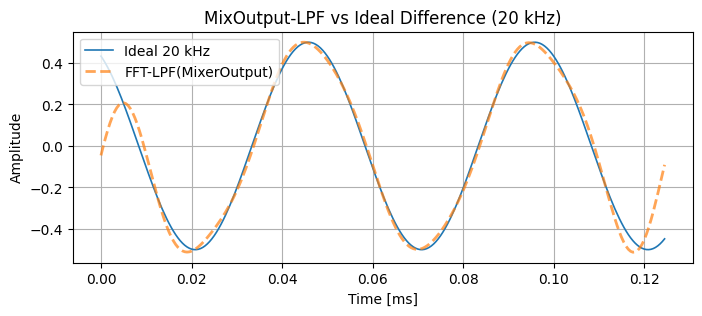

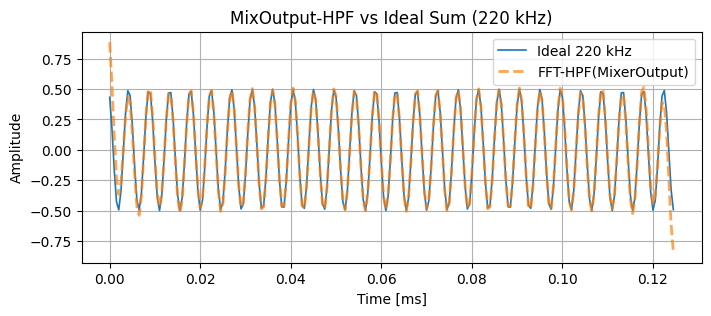

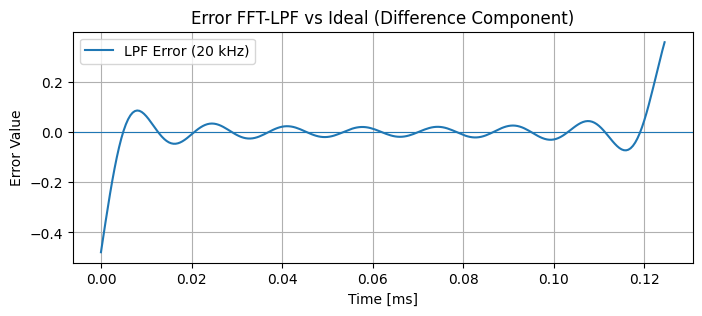

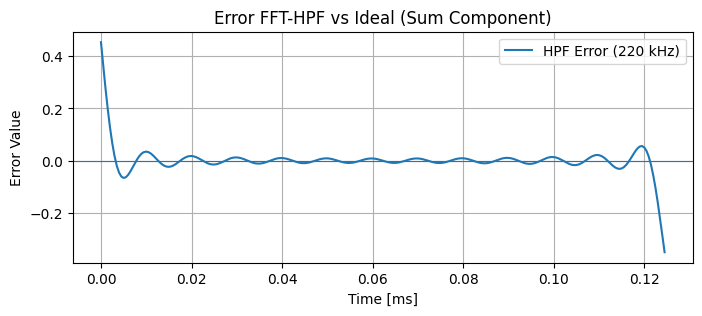

In [115]:
# ================================
# 1. 주파수 영역 Ideal Filter (No FIR/Window)
# ================================

#
# RF Mixer out Sample 수
#
N = len(y_rf)

#
# 1. FFT based on FFT_SIZE
#       FFT  (시간->주파수 영역)

#
Y = np.fft.rfft(y_rf)
freqs = np.fft.rfftfreq(N, d=1.0/fs)

#
# 2.Find LPF/HPF based on Frequency Domain
#       FFT 기반으로 Filter Mask 생성 및 적용
#       LPF (60KHz)/ HPF (100KHz) 마스크 생성
#
lpf_mask = (np.abs(freqs) <= lpf_cutoff)
hpf_mask = (np.abs(freqs) >= hpf_cutoff)

#
# 3. Used LPF/HPF Mask in Frequncy Domain
#       Frequency based on FFT_SIZE 
#
Y_lpf = Y * lpf_mask  # 
Y_hpf = Y * hpf_mask  # 

#
# 4. Change Frequncy to Time domain by IFFT
#       IFFT 주파수 -> 시간 영역 
#
y_lpf = np.fft.irfft(Y_lpf, n=N)
y_hpf = np.fft.irfft(Y_hpf, n=N)


display(Markdown(        
        f"*  FFT Filter \n\n"
        f"| Parameter Summary      | Parameter Value |\n"
        f"| ------------------     | ----------------|\n"
        f"| MixerOut Samples    | `{N}`           | \n"
        f"| Ideal 20K Samples   | `{len(ideal_020k)}` |   \n"         
        f"| Ideal 220K Samples  | `{len(ideal_220k)}` |   \n"         
        f"| FFT_SIZE            | `{len(Y)}`      | \n"
        f"| LPF (FFT_SIZE)      | `{len(lpf_mask),len(Y_lpf)}` | \n"
        f"| HPF (FFT_SIZE)      | `{len(hpf_mask),len(Y_hpf)}` | \n"
        f"| IFFT_SIZE (LPF)     | `{len(y_lpf)}`  | \n"   
        f"| IFFT_SIZE (HPF)     | `{len(y_hpf)}`        | \n"                
        f"| LO Frequency        | `{f_lo/1000:.1f} kHz` | \n"
        f"| RF Frequency        | `{f_rf/1000:.1f} kHz`    | \n"
        f"| Difference Freq     | `{f_dif_1/1000:.1f} kHz` |   \n"
       
))


# ================================
# 2. 유효 구간 (지연 없음 → 전체 사용)
# ================================
t_valid      = t
y_lpf_valid  = y_lpf
y_hpf_valid  = y_hpf

ideal_20k_valid  = ideal_020k
ideal_220k_valid = ideal_220k

# ================================
# 3. Plot: LPF vs Ideal 20 kHz
# ================================
plt.figure()
plt.plot(t_valid*1000, ideal_20k_valid, label="Ideal 20 kHz", linewidth=1.2)
plt.plot(t_valid*1000, y_lpf_valid,     label="FFT-LPF(MixerOutput)", linewidth=2.0, linestyle="--", alpha=0.7)
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("MixOutput-LPF vs Ideal Difference (20 kHz)")
plt.legend()
plt.grid(True)
plt.show()

# ================================
# 4. Plot: HPF vs Ideal 220 kHz
# ================================
plt.figure()
plt.plot(t_valid*1000, ideal_220k_valid, label="Ideal 220 kHz", linewidth=1.2)
plt.plot(t_valid*1000, y_hpf_valid,      label="FFT-HPF(MixerOutput)", linewidth=2.0, linestyle="--", alpha=0.7)
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("MixOutput-HPF vs Ideal Sum (220 kHz)")
plt.legend()
plt.grid(True)
plt.show()

# ================================
# 5. Error 계산
# ================================
error_lpf = y_lpf_valid - ideal_20k_valid
error_hpf = y_hpf_valid - ideal_220k_valid

plt.figure()
plt.plot(t_valid*1000, error_lpf, label="LPF Error (20 kHz)")
plt.axhline(0, linewidth=0.8)
plt.title("Error FFT-LPF vs Ideal (Difference Component)")
plt.xlabel("Time [ms]")
plt.ylabel("Error Value")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(t_valid*1000, error_hpf, label="HPF Error (220 kHz)")
plt.axhline(0, linewidth=0.8)
plt.title("Error FFT-HPF vs Ideal (Sum Component)")
plt.xlabel("Time [ms]")
plt.ylabel("Error Value")
plt.grid(True)
plt.legend()
plt.show()


### **1.2 FIR-Convolution**

<br/>

Removed Window and only used Convolution  

[Window Designn method](https://en.wikipedia.org/wiki/Finite_impulse_response#Window_design_method)     

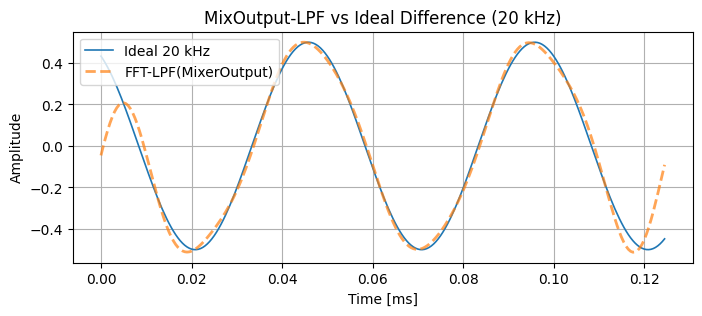

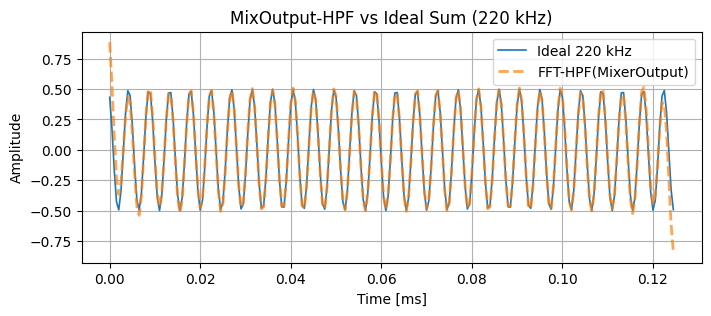

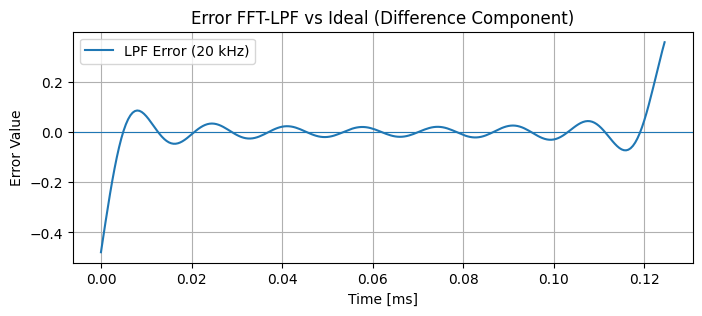

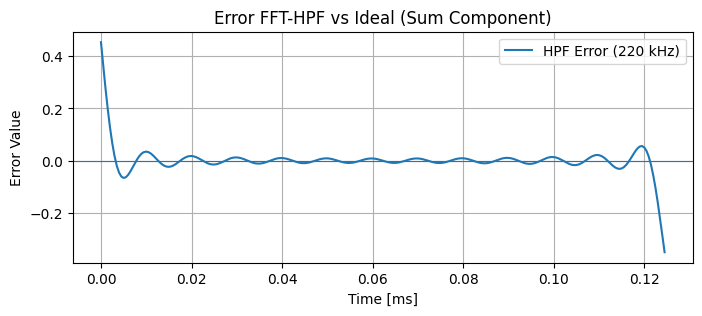

In [116]:
# ================================
# 1. 주파수 영역 Ideal Filter 정의 (마스크)
# ================================

N = len(y_rf)

# FFT
Y = np.fft.rfft(y_rf)
freqs = np.fft.rfftfreq(N, d=1.0/fs)

# 이상적인 LPF / HPF 마스크 (0/1)
lpf_mask = (np.abs(freqs) <= lpf_cutoff).astype(float)
hpf_mask = (np.abs(freqs) >= hpf_cutoff).astype(float)

#
#   마스크 → 시간 영역 임펄스 응답 (필터 커널)
#   1. 1D Convolution Kernel 생성
#
h_lpf = np.fft.irfft(lpf_mask, n=N)   # Ideal LPF impulse
h_hpf = np.fft.irfft(hpf_mask, n=N)   # Ideal HPF impulse


# ================================
# 2. 1D Convolution으로 직접 필터링
# ================================

#
# full convolution (길이: N + N - 1 = 2N-1)
#
y_lpf_full = np.convolve(y_rf, h_lpf, mode="full")
y_hpf_full = np.convolve(y_rf, h_hpf, mode="full")

# 필터 길이만큼의 지연(대칭 커널이므로 중앙 정렬)
delay = (len(h_lpf) - 1) // 2   # 여기서는 (N-1)//2

start = delay
end   = start + N               # 원래 입력 길이에 맞추기

y_lpf = y_lpf_full[start:end]
y_hpf = y_hpf_full[start:end]



# ================================
# 3. Plot: LPF vs Ideal 20 kHz
# ================================
plt.figure()
plt.plot(t_valid*1000, ideal_20k_valid, label="Ideal 20 kHz", linewidth=1.2)
plt.plot(t_valid*1000, y_lpf_valid,     label="FFT-LPF(MixerOutput)", linewidth=2.0, linestyle="--", alpha=0.7)
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("MixOutput-LPF vs Ideal Difference (20 kHz)")
plt.legend()
plt.grid(True)
plt.show()

# ================================
# 4. Plot: HPF vs Ideal 220 kHz
# ================================
plt.figure()
plt.plot(t_valid*1000, ideal_220k_valid, label="Ideal 220 kHz", linewidth=1.2)
plt.plot(t_valid*1000, y_hpf_valid,      label="FFT-HPF(MixerOutput)", linewidth=2.0, linestyle="--", alpha=0.7)
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("MixOutput-HPF vs Ideal Sum (220 kHz)")
plt.legend()
plt.grid(True)
plt.show()

# ================================
# 5. Error 계산
# ================================
error_lpf = y_lpf_valid - ideal_20k_valid
error_hpf = y_hpf_valid - ideal_220k_valid

plt.figure()
plt.plot(t_valid*1000, error_lpf, label="LPF Error (20 kHz)")
plt.axhline(0, linewidth=0.8)
plt.title("Error FFT-LPF vs Ideal (Difference Component)")
plt.xlabel("Time [ms]")
plt.ylabel("Error Value")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(t_valid*1000, error_hpf, label="HPF Error (220 kHz)")
plt.axhline(0, linewidth=0.8)
plt.title("Error FFT-HPF vs Ideal (Sum Component)")
plt.xlabel("Time [ms]")
plt.ylabel("Error Value")
plt.grid(True)
plt.legend()
plt.show()


### **1.3 FIR-Convolution**

<br/>

Window and short Convolution  

[Window Designn method](https://en.wikipedia.org/wiki/Finite_impulse_response#Window_design_method)   

61 61


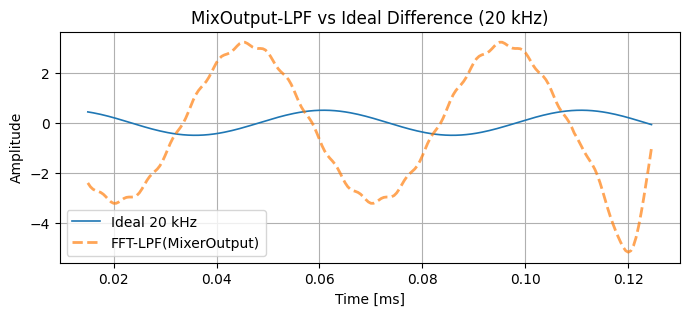

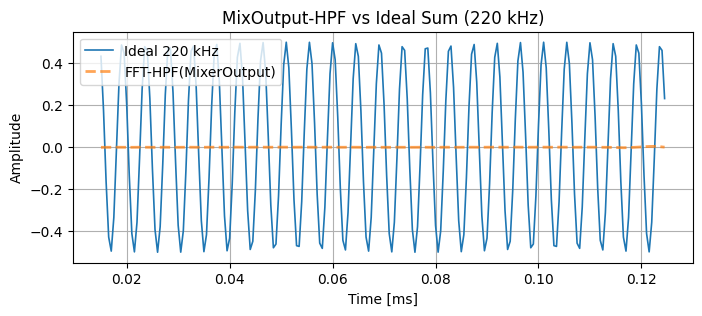

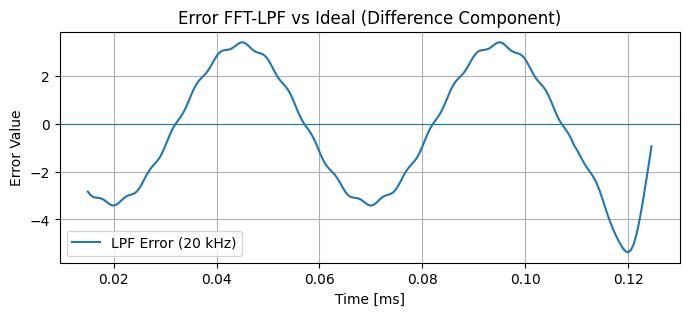

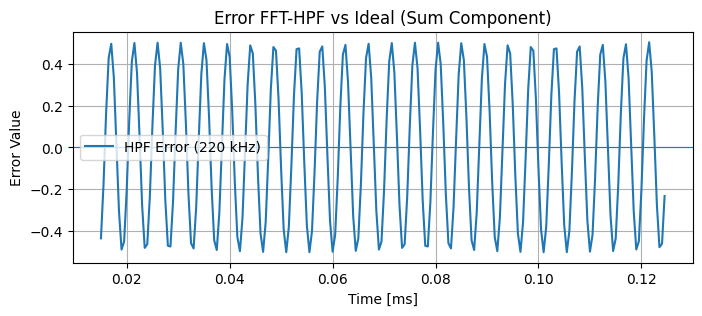

In [117]:
# ================================
# 1. 주파수 영역 Ideal Filter 정의 (마스크)
# ================================

N = len(y_rf)
# 0) 파라미터: 원하는 kernel 길이 (반드시 홀수)
M = len(y_rf)//4 - 1  # 예: 63 tap. 원하면 31, 127 등으로 바꿔도 됨.

# 1) 길이 N짜리 ideal impulse (이미 freq mask 정의돼 있다고 가정)
h_lpf_long = np.fft.irfft(lpf_mask.astype(float), n=N)
h_hpf_long = np.fft.irfft(hpf_mask.astype(float), n=N)

# 2) 중앙 기준으로 M개만 잘라서 short kernel 생성
center = N // 2
half   = M // 2

h_lpf_short = h_lpf_long[center-half : center+half+1]
h_hpf_short = h_hpf_long[center-half : center+half+1]

print(len(h_lpf_short), len(h_hpf_short))  # 둘 다 M이어야 함
w = np.hamming(M)

h_lpf_short *= w
h_hpf_short *= w

h_lpf_short /= np.sum(h_lpf_short)

# ================================
# 2. 1D Convolution으로 직접 필터링
# ================================

# ================================
# Short kernel FIR로 conv 적용
# ================================
y_lpf = np.convolve(y_rf, h_lpf_short, mode="same")
y_hpf = np.convolve(y_rf, h_hpf_short, mode="same")

# group delay = (M-1)/2 샘플
delay = (M - 1) // 2

t_valid      = t[delay:]
y_lpf_valid  = y_lpf[delay:]
y_hpf_valid  = y_hpf[delay:]

ideal_20k_valid  = ideal_020k[:len(y_lpf_valid)]
ideal_220k_valid = ideal_220k[:len(y_hpf_valid)]


# ================================
# 3. Plot: LPF vs Ideal 20 kHz
# ================================
plt.figure()
plt.plot(t_valid*1000, ideal_20k_valid, label="Ideal 20 kHz", linewidth=1.2)
plt.plot(t_valid*1000, y_lpf_valid,     label="FFT-LPF(MixerOutput)", linewidth=2.0, linestyle="--", alpha=0.7)
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("MixOutput-LPF vs Ideal Difference (20 kHz)")
plt.legend()
plt.grid(True)
plt.show()

# ================================
# 4. Plot: HPF vs Ideal 220 kHz
# ================================
plt.figure()
plt.plot(t_valid*1000, ideal_220k_valid, label="Ideal 220 kHz", linewidth=1.2)
plt.plot(t_valid*1000, y_hpf_valid,      label="FFT-HPF(MixerOutput)", linewidth=2.0, linestyle="--", alpha=0.7)
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("MixOutput-HPF vs Ideal Sum (220 kHz)")
plt.legend()
plt.grid(True)
plt.show()

# ================================
# 5. Error 계산
# ================================
error_lpf = y_lpf_valid - ideal_20k_valid
error_hpf = y_hpf_valid - ideal_220k_valid

plt.figure()
plt.plot(t_valid*1000, error_lpf, label="LPF Error (20 kHz)")
plt.axhline(0, linewidth=0.8)
plt.title("Error FFT-LPF vs Ideal (Difference Component)")
plt.xlabel("Time [ms]")
plt.ylabel("Error Value")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(t_valid*1000, error_hpf, label="HPF Error (220 kHz)")
plt.axhline(0, linewidth=0.8)
plt.title("Error FFT-HPF vs Ideal (Sum Component)")
plt.xlabel("Time [ms]")
plt.ylabel("Error Value")
plt.grid(True)
plt.legend()
plt.show()
